In [1]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.cm

sns.set()

/opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Aprendizaje no supervisado

- Problemas de reconocimiento de patrones donde el grupo de puntos de entrenamineto no tienen una variable target
- Quiero descubrir grupos de datos con características similares
- No tengo una medida de éxito directa
- Muchos métodos son heurísticas: estrategias, reglas, silogismos.

Generamos puntos en un espacio 2D que correspondan a 4 clusters, para ello usamos make_blobs de sklearn:

Text(0.5, 0, 'X1')

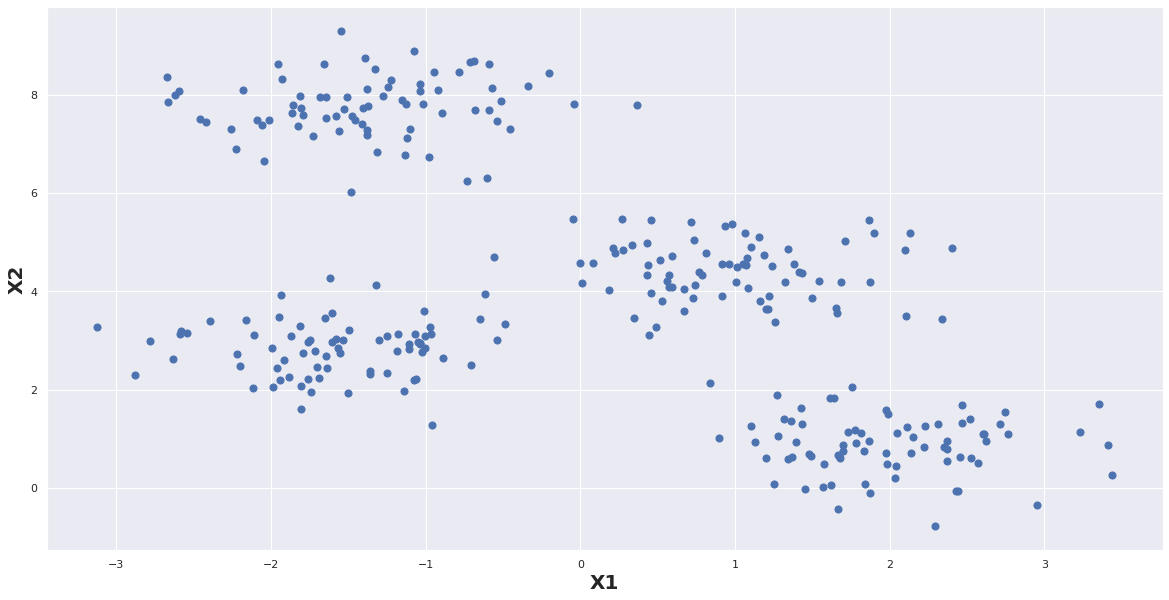

In [2]:
X, y_labels = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

## K-means

Usamos la herramienta KMeans, que busca los clusteres de puntos, retornando los labels de cada punto (a qué clase pertenece) y los centroides de dichos clusteres.

In [3]:
from sklearn.cluster import KMeans

In [4]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Text(0.5, 0, 'X1')

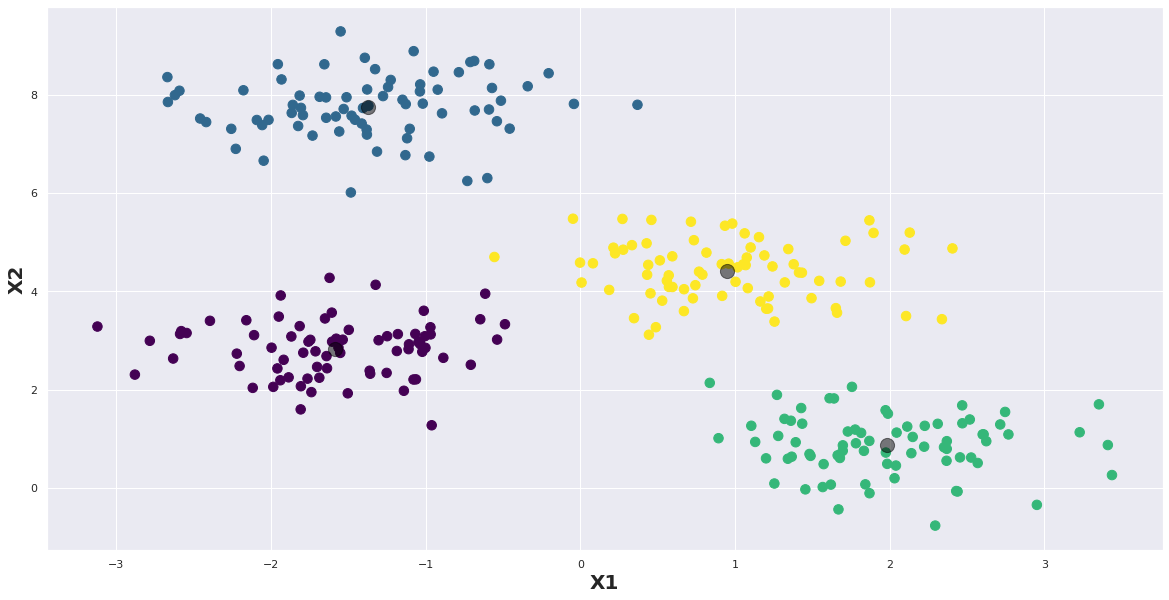

In [5]:
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=90, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")


In [6]:
clusters = np.unique(y_kmeans)
clusters

array([0, 1, 2, 3], dtype=int32)

Pero, ¿cómo funciona el algoritmo?

Text(0.5, 0, 'X1')

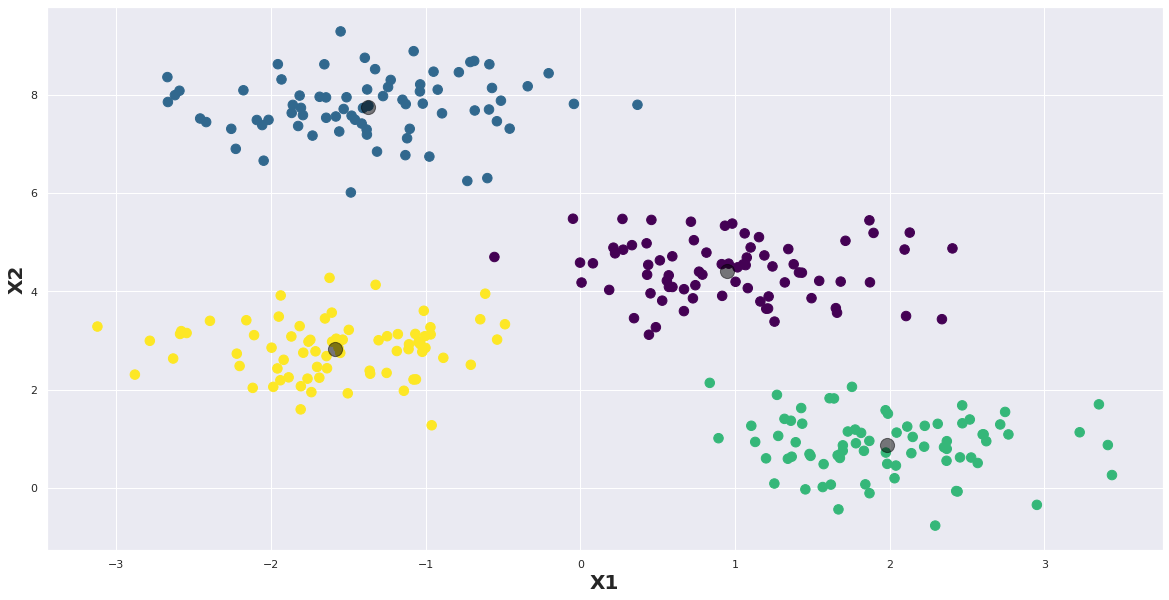

In [7]:
from sklearn.metrics import pairwise_distances_argmin


def kmeans_distorsion(X, centers):
    distortion = 0
    labels = pairwise_distances_argmin(X, centers)
    for i in range(len(labels)):
        distortion += np.linalg.norm(X[i] - centers[labels[i]])
    return distortion


def find_clusters(X, n_clusters, rseed=2):
    # 1. Seleccionamos de manera aleatoria los primeros valores de los centroides
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    j = 0
    while True:
        """2a. Asignamos a qué cluster pertenece según su cercanía al centroide
           pairwise_distances_argmin retorna array de indices, cada índice corresponde
           con el índice del controide más cercano para ese punto"""

        labels = pairwise_distances_argmin(X, centers)

        """2b. Buscamos los nuevo centroides, calculados como el promedio
           (en cada dimension) de los puntos de cada cluster"""
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

        """ 2c. si los centroides no cambiaron respecto al paso anterior, paro"""
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels, kmeans_distorsion(X, centers)


plt.figure(figsize=(20, 10))
centers, labels, error = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=90, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")


Observamos ahora como se mueven los centroides en las iteraciones del código anterior:

In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from functools import partial


def find_clusters_limited_iters(X, n_clusters, iters, rseed=2):
    """1. Seleccionamos de manera aleatoria los primeros valores de los centroides"""
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    j = 0
    for i in range(iters):
        """2a. Asignamos a qué cluster pertenece según su cercanía al centroide
           pairwise_distances_argmin retorna array de indices, cada índice corresponde con el índice del controide
           más cercano para ese punto"""

        labels = pairwise_distances_argmin(X, centers)

        """2b. Buscamos los nuevo centroides, calculados como el promedio (en cada dimension) de los puntos de
           cada cluster"""
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

        # 2c. si los centroides no cambiaron respecto al paso anterior, stop
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels, kmeans_distorsion(X, centers)


def plot_clusters(X, n_clusters, iters, rseed=2):
    plt.figure(figsize=(20, 10))
    centers, labels, error = find_clusters_limited_iters(
        X, n_clusters, iters, rseed=rseed
    )
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=90, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.ylabel("X2", fontsize=20, weight="bold")
    plt.xlabel("X1", fontsize=20, weight="bold")
    plt.title("Distortion: %f" % error, fontsize=20)
    plt.show()


interact(
    plot_clusters, X=fixed(X), n_clusters=fixed(4), rseed=fixed(2), iters=(1, 10, 1)
)

interactive(children=(IntSlider(value=5, description='iters', max=10, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_clusters(X, n_clusters, iters, rseed=2)>

### Matriz de similaridad

In [9]:
ordered_points = X[np.where(y_kmeans == clusters[0])]
for i in clusters[1:]:
    points_cluster_i_index = np.where(y_kmeans == i)
    points_cluster_i = X[points_cluster_i_index]
    ordered_points = np.vstack((ordered_points, points_cluster_i))

In [10]:
distance_matrix = euclidean_distances(ordered_points, ordered_points)

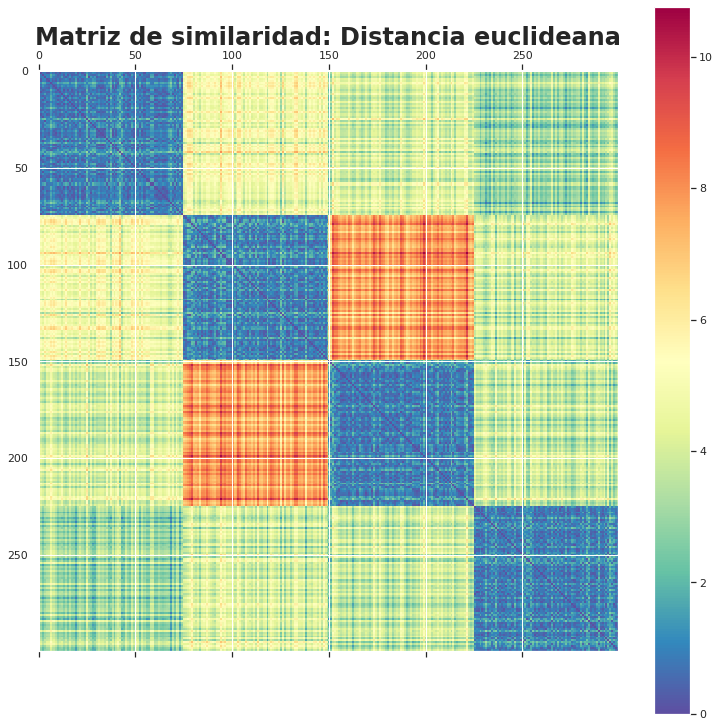

In [11]:
fig, ax = plt.subplots(figsize=(13, 13))
cax = ax.matshow(
    distance_matrix, interpolation='nearest', cmap=matplotlib.cm.Spectral_r
)
fig.colorbar(cax)
ax.grid(True)
plt.title("Matriz de similaridad: Distancia euclideana", fontsize=24, weight="bold")
plt.show()

¿Qué pasa cuando la inicialización de los centroides no es muy feliz?

Text(0.5, 0, 'X1')

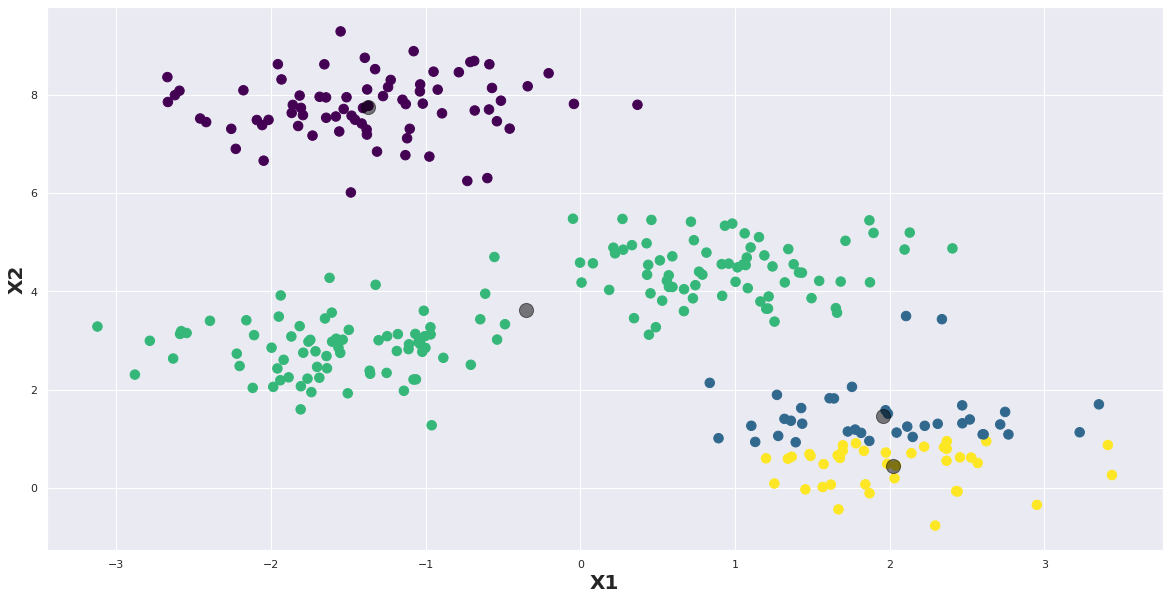

In [12]:
centers, labels, error = find_clusters(X, 4, rseed=0)
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=90, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

In [13]:
interact(
    plot_clusters, X=fixed(X), n_clusters=fixed(4), rseed=fixed(0), iters=(1, 10, 1)
)

interactive(children=(IntSlider(value=5, description='iters', max=10, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_clusters(X, n_clusters, iters, rseed=2)>

In [14]:
clusters = np.unique(labels)
ordered_points = X[np.where(y_kmeans == clusters[0])]
for i in clusters[1:]:
    points_cluster_i_index = np.where(labels == i)
    points_cluster_i = X[points_cluster_i_index]
    ordered_points = np.vstack((ordered_points, points_cluster_i))

In [15]:
distance_matrix = euclidean_distances(ordered_points, ordered_points)

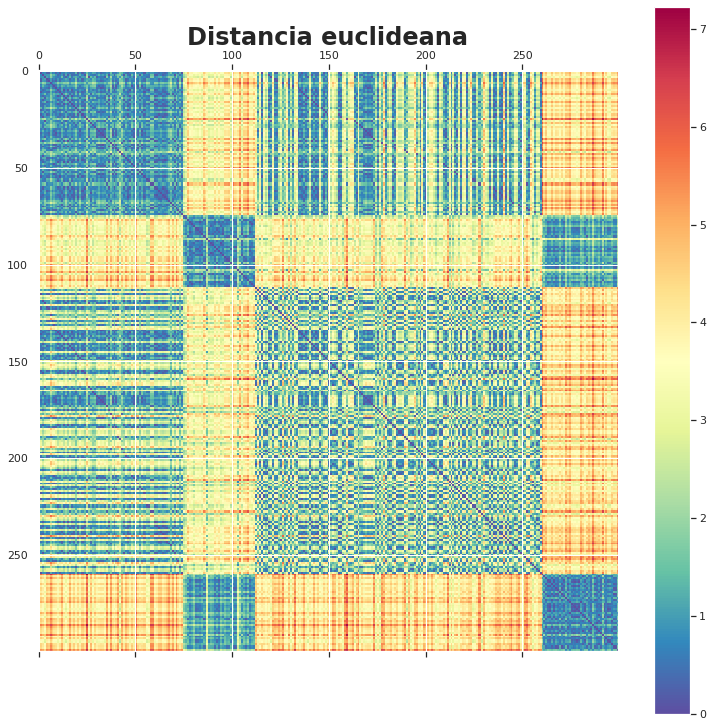

In [16]:
fig, ax = plt.subplots(figsize=(13, 13))
cax = ax.matshow(
    distance_matrix, interpolation='nearest', cmap=matplotlib.cm.Spectral_r
)
fig.colorbar(cax)
ax.grid(True)
plt.title("Distancia euclideana", fontsize=24, weight="bold")
plt.show()

## Clustering aglomerativo

- No tengo que explícitamente dar número de clusters k* de antemano
- Se produce una representación jerárquica (dendrograma).
- Clústeres de un nivel superior se forman por la unión de clústeres de niveles inferiores.
- En el nivel más inferior tengo clusteres formados por 1 punto dato, en el nivel más superior tendo 1 cluster formado por todos los puntos dato.

Usamos [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) de sklearn: "Recursively merges the pair of clusters that minimally increases a given linkage distance"

In [17]:
from sklearn.cluster import AgglomerativeClustering

In [18]:
clustering = AgglomerativeClustering(n_clusters=4).fit(X)

In [19]:
clustering.labels_

array([2, 0, 1, 0, 2, 2, 3, 1, 0, 0, 3, 0, 1, 0, 2, 1, 1, 2, 3, 3, 2, 2,
       1, 3, 3, 1, 2, 1, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2, 1, 3, 1, 1,
       3, 3, 0, 3, 0, 2, 3, 2, 0, 2, 2, 3, 0, 3, 0, 2, 0, 1, 0, 3, 3, 3,
       0, 2, 0, 3, 1, 3, 0, 3, 3, 0, 3, 1, 2, 0, 2, 1, 2, 2, 0, 1, 2, 1,
       0, 0, 1, 2, 0, 3, 3, 1, 2, 2, 1, 3, 0, 2, 0, 2, 1, 2, 2, 1, 0, 1,
       3, 3, 2, 0, 2, 1, 0, 2, 2, 1, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 0, 3,
       3, 2, 0, 3, 3, 0, 1, 0, 0, 3, 1, 3, 1, 3, 0, 1, 0, 0, 0, 1, 0, 1,
       2, 3, 0, 3, 2, 1, 0, 1, 1, 2, 1, 3, 3, 1, 2, 1, 1, 0, 2, 1, 3, 0,
       2, 2, 1, 3, 2, 1, 3, 3, 1, 1, 1, 1, 2, 0, 1, 3, 1, 1, 3, 3, 3, 1,
       3, 0, 1, 3, 2, 3, 1, 0, 3, 0, 1, 0, 1, 3, 1, 1, 0, 3, 3, 2, 2, 1,
       0, 2, 2, 3, 2, 3, 1, 0, 0, 1, 1, 0, 1, 2, 3, 1, 2, 3, 0, 3, 2, 1,
       2, 0, 0, 0, 0, 3, 3, 0, 1, 3, 2, 1, 3, 3, 3, 2, 2, 0, 1, 1, 3, 2,
       0, 3, 1, 0, 1, 2, 2, 3, 3, 1, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 2, 2,
       0, 3, 0, 1, 2, 2, 0, 0, 0, 2, 2, 1, 0, 3])

Text(0.5, 0, 'X1')

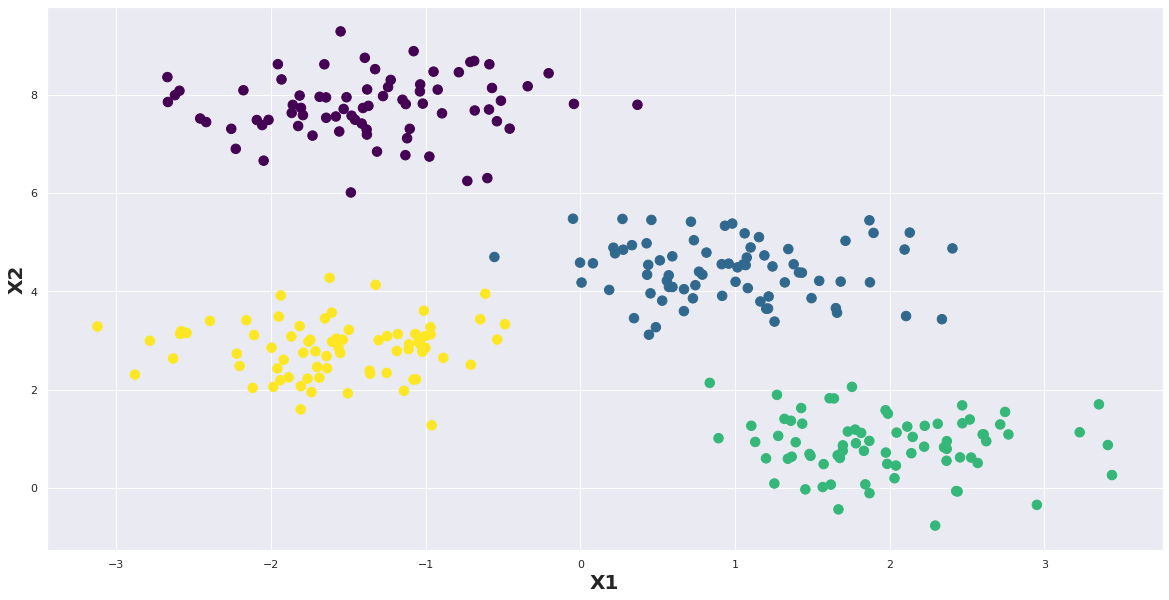

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=90, cmap='viridis')
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

In [21]:
def plot_agglometive(X, n_clusters):
    plt.figure(figsize=(20, 10))
    clustering = AgglomerativeClustering(n_clusters).fit(X)
    plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=90, cmap='viridis')
    plt.ylabel("X2", fontsize=20, weight="bold")
    plt.xlabel("X1", fontsize=20, weight="bold")
    plt.show()


interact(plot_agglometive, X=fixed(X), n_clusters=(1, 20, 1))

interactive(children=(IntSlider(value=10, description='n_clusters', max=20, min=1), Output()), _dom_classes=('…

<function __main__.plot_agglometive(X, n_clusters)>

Este método nos permite tener un ordenamiento jerárquico de las observaciones en lo que llamamos un dendrograma: nos indica qué grupo de observaciones es más parecida a otra. Observaciones que se unen más abajo en el dendrograma son más similares.

In [22]:
from scipy.cluster.hierarchy import dendrogram

In [23]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

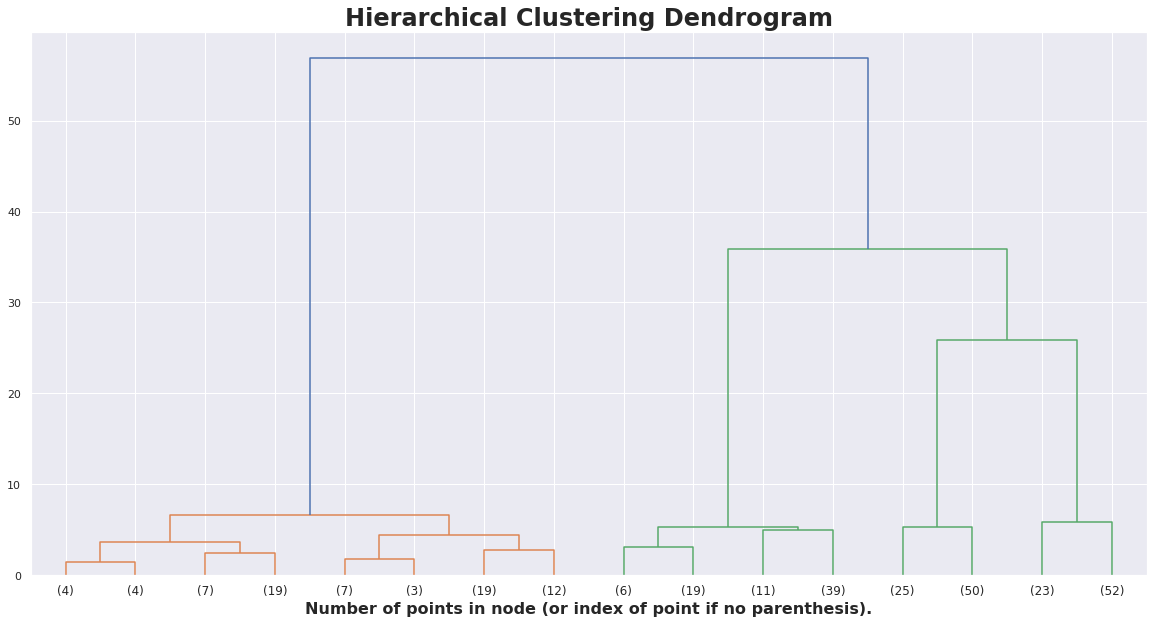

In [24]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X)
plt.figure(figsize=(20, 10))
plot_dendrogram(model, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram', fontsize=24, weight="bold")
plt.xlabel(
    "Number of points in node (or index of point if no parenthesis).",
    fontsize=16,
    weight="bold",
)

In [25]:
from sklearn.datasets import make_moons

In [26]:
X, y = make_moons(200, noise=0.05, random_state=0)

Ahora vemos que pasa cuando se complican un poco más los datos:

Text(0.5, 0, 'X1')

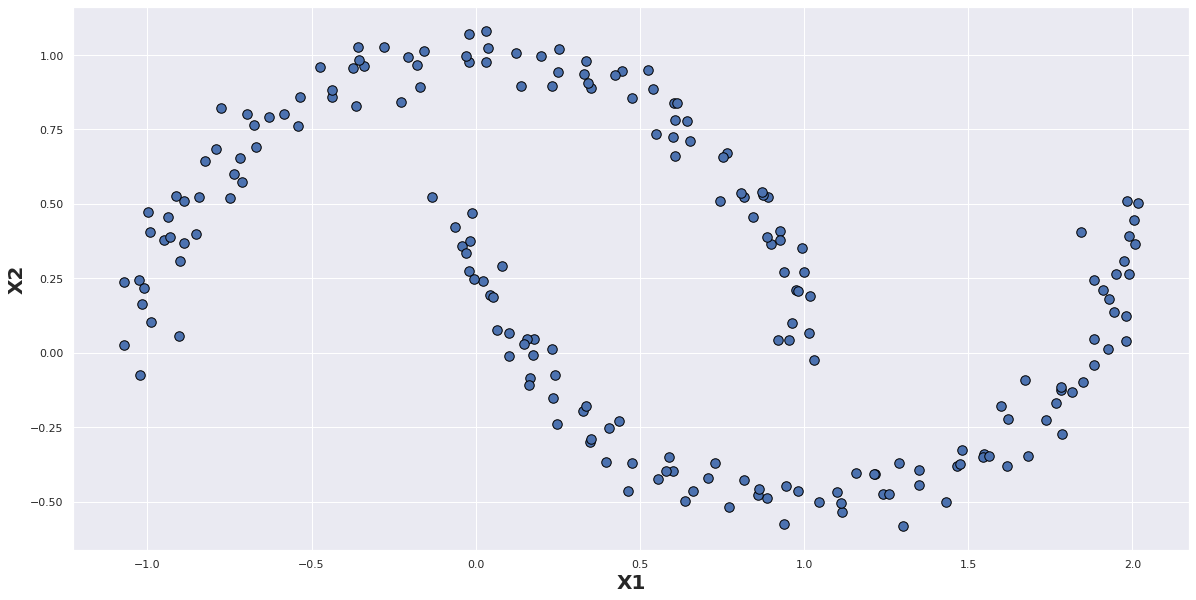

In [27]:
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], edgecolor='black', s=90, cmap='viridis')
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

Qué pasa si aplicamos kmeans a esto?

Text(0.5, 0, 'X1')

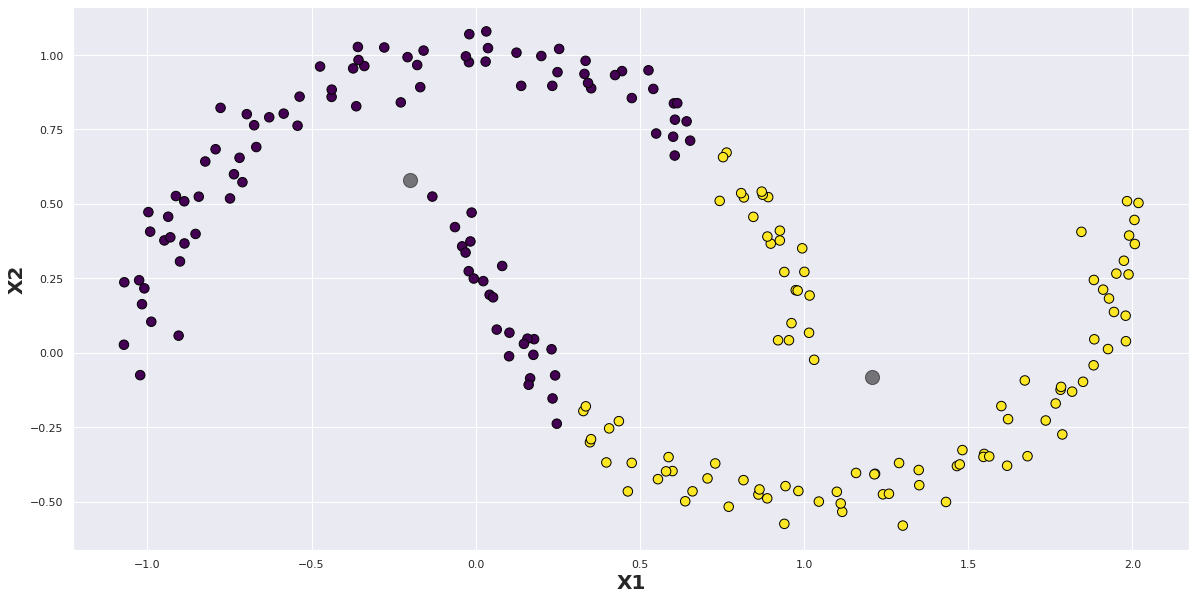

In [28]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
labels = kmeans.predict(X)
centers = kmeans.cluster_centers_
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], c=labels, edgecolor='black', s=90, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

In [29]:
cluster_0_id = np.where(labels == 0)
cluster_1_id = np.where(labels == 1)
cluster_0 = X[cluster_0_id]
cluster_1 = X[cluster_1_id]

In [30]:
ordered_points = np.append(cluster_0, cluster_1, axis=0)

In [31]:
distance_matrix = euclidean_distances(ordered_points, ordered_points)

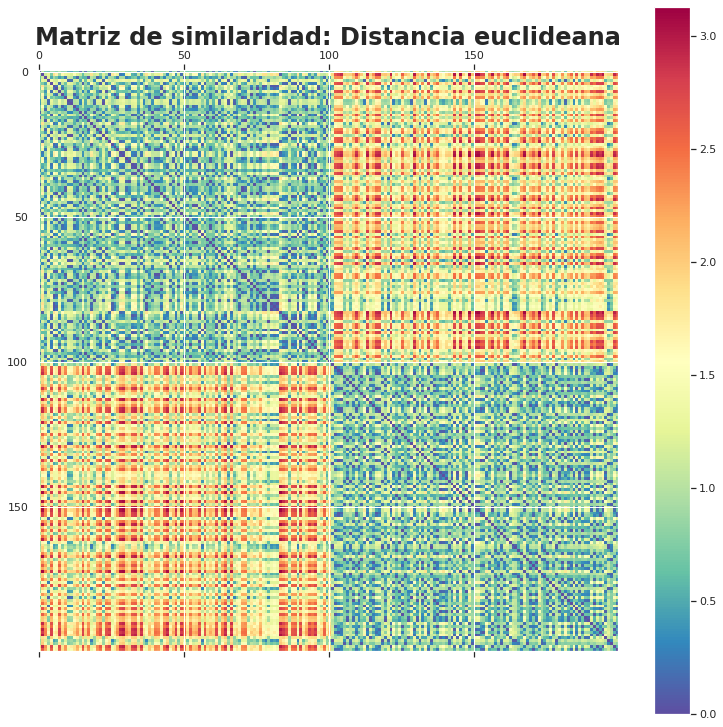

In [32]:
fig, ax = plt.subplots(figsize=(13, 13))
cax = ax.matshow(
    distance_matrix, interpolation='nearest', cmap=matplotlib.cm.Spectral_r
)
fig.colorbar(cax)
ax.grid(True)
plt.title("Matriz de similaridad: Distancia euclideana", fontsize=24, weight="bold")
plt.show()

Vemos que los clusters que encuentra el algoritmo no son los correctos. :(
Que nos da Agglomerative clustering?

In [33]:
from sklearn.neighbors import kneighbors_graph

In [34]:
def plot_agglometive(X, n_clusters):
    plt.figure(figsize=(20, 10))
    clustering = AgglomerativeClustering(n_clusters).fit(X)
    plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=90, cmap='viridis')
    plt.ylabel("X2", fontsize=20, weight="bold")
    plt.xlabel("X1", fontsize=20, weight="bold")
    plt.show()


interact(plot_agglometive, X=fixed(X), n_clusters=(1, 20, 1))

interactive(children=(IntSlider(value=10, description='n_clusters', max=20, min=1), Output()), _dom_classes=('…

<function __main__.plot_agglometive(X, n_clusters)>

## DBSCAN
- No tengo que especificar la cantidad de clusters.
- Para este método los clusters son zonas de alta densidad de puntos, separados por zonas con baja densidad de puntos.
- Este método clasifica los puntos en: puntos borde, puntos core o puntos ruido(noise)

Que pasa con DBSCAN?

Usamos la herramienta DBSCAN de sklearn

In [35]:
from sklearn.cluster import DBSCAN

Los parámetros más importantes son:
 - **eps**: da la noción de cercanía, es la máxima distancia dentro de la cual 2 puntos son considerados vecinos.
 - **min_samples**: cantidad de vecinos que tiene que tener un punto para se considerado como **core point**.

In [36]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

DBSCAN nos da los *core points* y los *noise points*, además de lac antidad de cluster encontrados y los labels para cada punto (a qué cluster pertenece)

In [37]:
db.core_sample_indices_

array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

Los noise points tendrán índice -1 al acceder a labels_ (ojo!)

In [38]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [39]:
db.labels_

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1])

In [40]:
n_clusters_

2

Text(0.5, 0, 'X1')

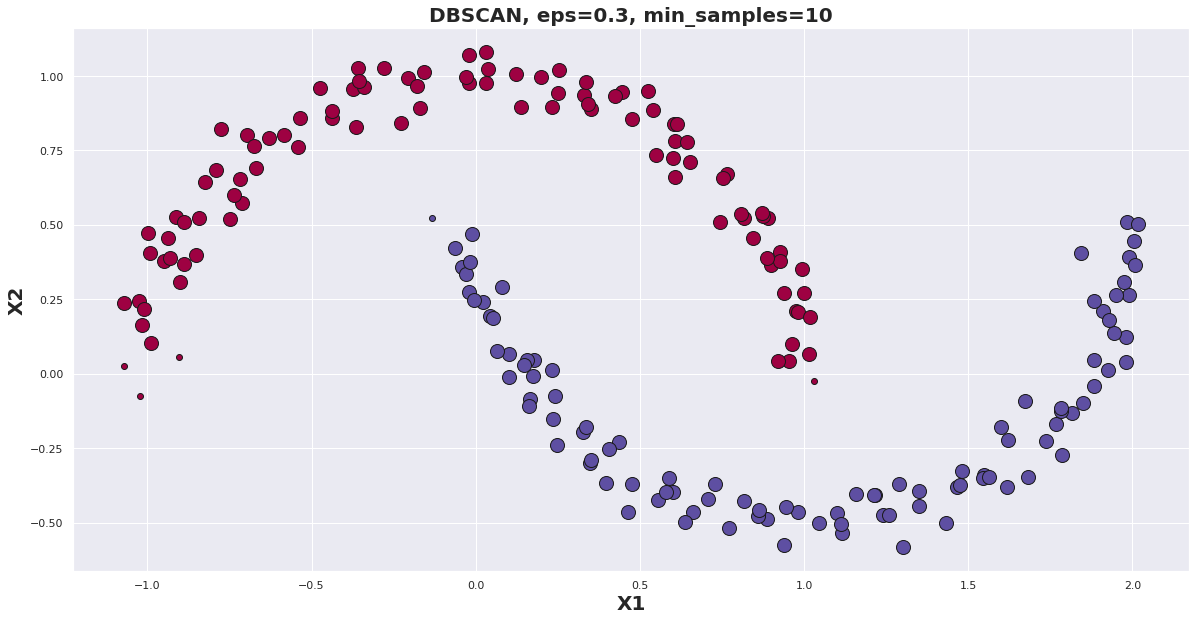

In [41]:
unique_labels = set(labels)
plt.figure(figsize=(20, 10))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
    )

plt.title("DBSCAN, eps=0.3, min_samples=10", fontsize=20, weight="bold")
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

Cambio **eps**, noción de cernanía.

In [42]:
db = DBSCAN(eps=0.2, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [43]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [44]:
n_clusters_

2

Text(0.5, 0, 'X1')

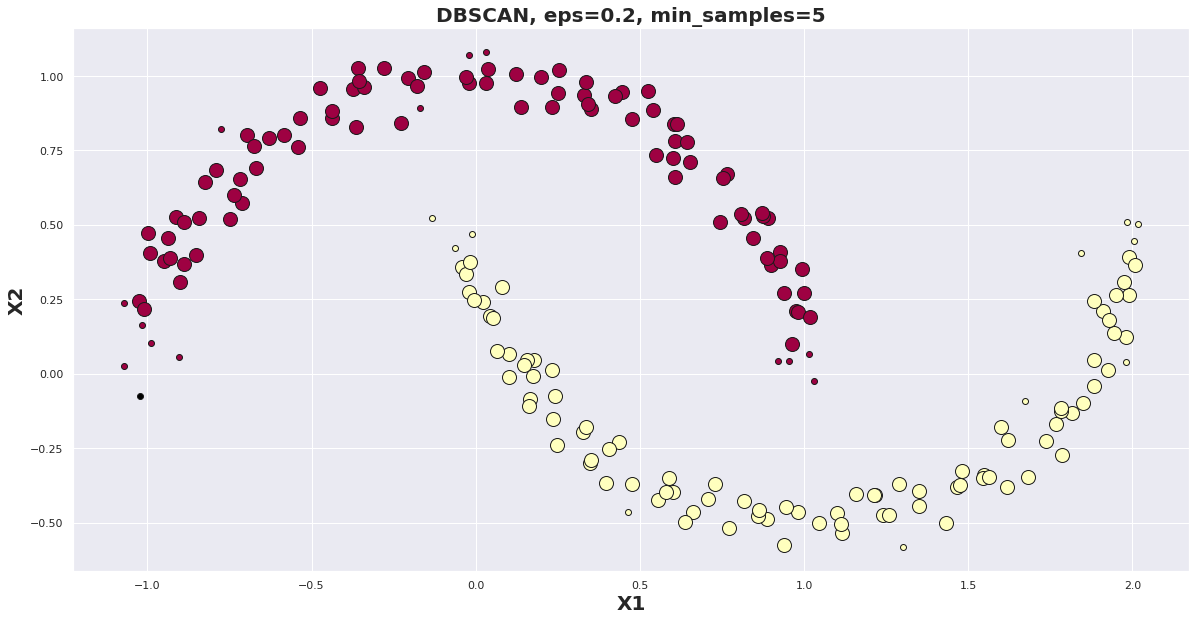

In [45]:
unique_labels = set(labels)
plt.figure(figsize=(20, 10))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
    )

plt.title("DBSCAN, eps=0.2, min_samples=5", fontsize=20, weight="bold")
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

In [46]:
db.labels_

array([ 0,  1,  1, -1,  1,  1,  0,  1,  0,  1,  0,  1,  1,  1,  0,  0,  0,
        1,  0,  0,  1,  1,  0,  1,  0,  1,  1,  1,  1,  0,  0,  0,  1,  1,
        0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  0,  1,  1,  0,
        1,  1,  0,  1,  0,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  1,  1,  1,  0,  1,  0,  0,  1,  1,  0,  1,  1,  1,
        0,  0,  0,  1,  1,  0,  0,  1,  0,  1,  1,  1,  1,  0,  1,  1,  1,
        0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,
        0,  0,  0,  1,  0,  1,  0,  0,  1,  1,  1,  0,  0,  0,  1,  1,  1,
        1,  0,  1,  0,  1,  1,  0,  0,  0,  0,  1,  1,  0,  1,  1,  1,  0,
        0,  1,  0,  1,  1,  0,  0,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1,
        0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  1])

In [47]:
cluster_0_id = np.where(db.labels_ == 0)
cluster_1_id = np.where(db.labels_ == 1)

In [48]:
cluster_0 = X[cluster_0_id]

In [49]:
cluster_1 = X[cluster_1_id]

In [50]:
ordered_points = np.append(cluster_0, cluster_1, axis=0)

In [51]:
distance_matrix = euclidean_distances(ordered_points, ordered_points)

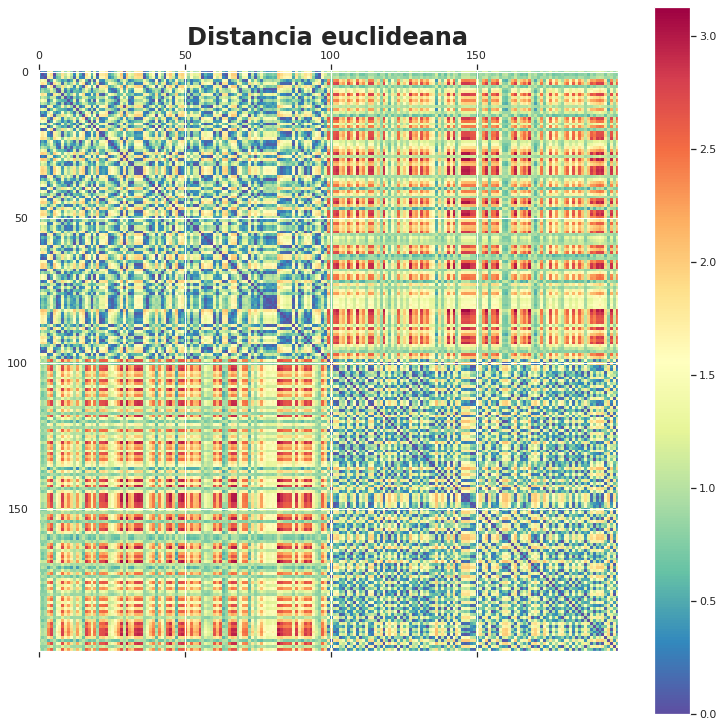

In [52]:
fig, ax = plt.subplots(figsize=(13, 13))
cax = ax.matshow(
    distance_matrix, interpolation='nearest', cmap=matplotlib.cm.Spectral_r
)
fig.colorbar(cax)
ax.grid(True)
plt.title("Distancia euclideana", fontsize=24, weight="bold")
plt.show()

Aumento **min_samples**

In [53]:
db = DBSCAN(eps=0.2, min_samples=13).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [54]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [55]:
n_clusters_

8

Text(0.5, 0, 'X1')

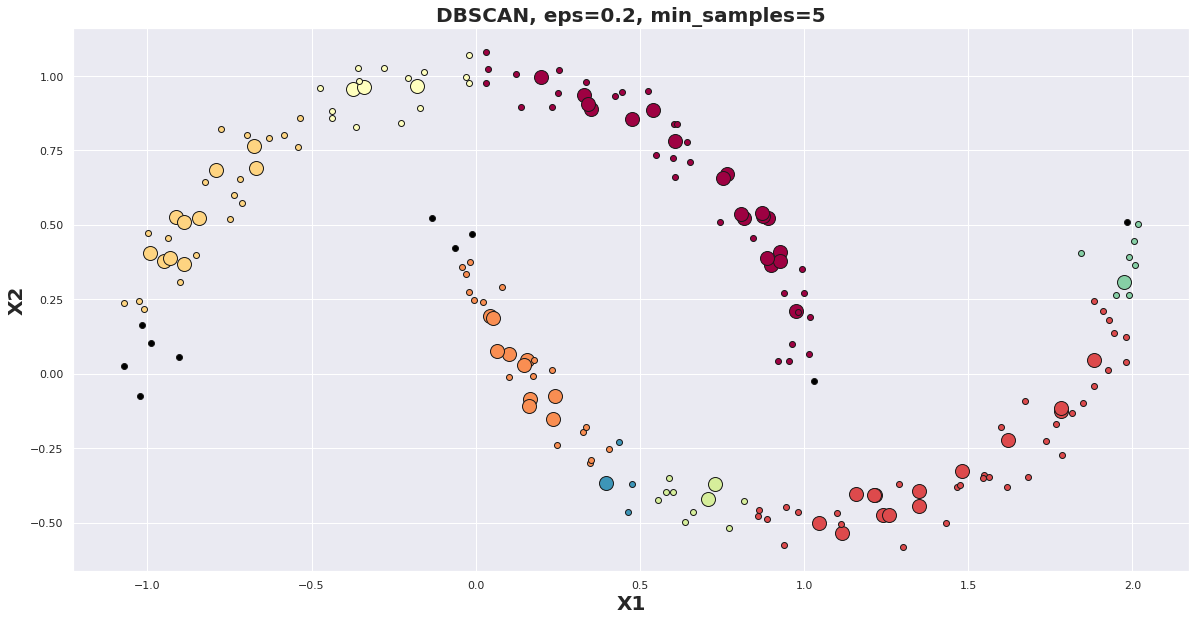

In [56]:
unique_labels = set(labels)
plt.figure(figsize=(20, 10))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
    )

plt.title("DBSCAN, eps=0.2, min_samples=5", fontsize=20, weight="bold")
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

Muchos menos core points, más clusters, más noise points

## Robustez

Text(0.5, 0, 'X1')

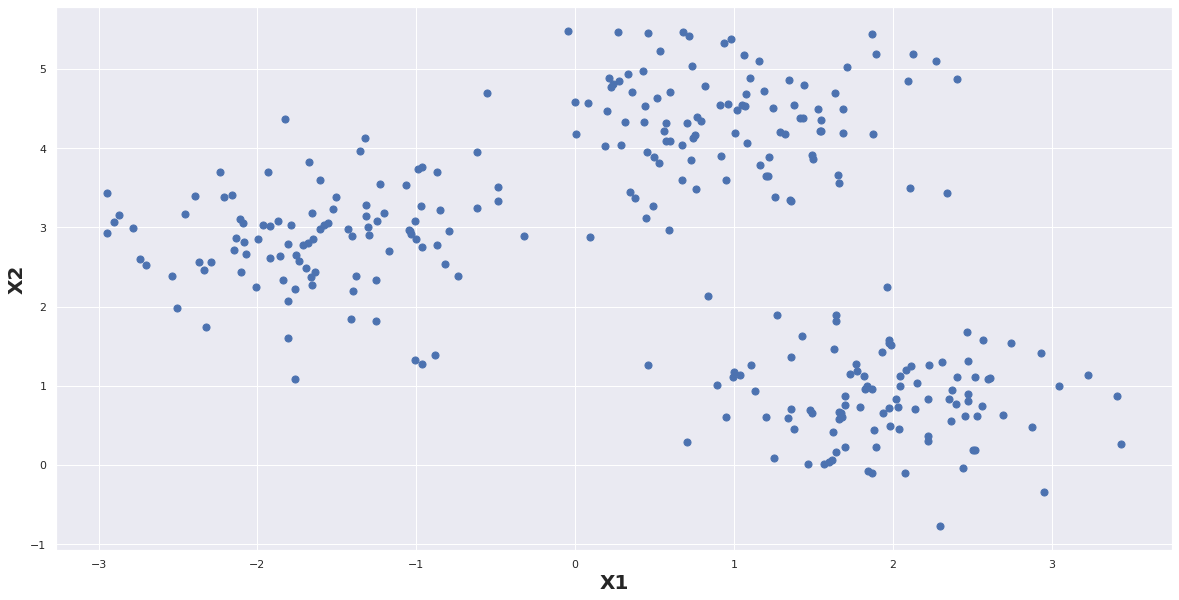

In [57]:
X, y_labels = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

¿Qué pasa si tenemos outliers?

In [58]:
X_out = np.vstack((X, ([-3, 6], [-4, 5], [-3.5, 4.5])))

Text(0.5, 0, 'X1')

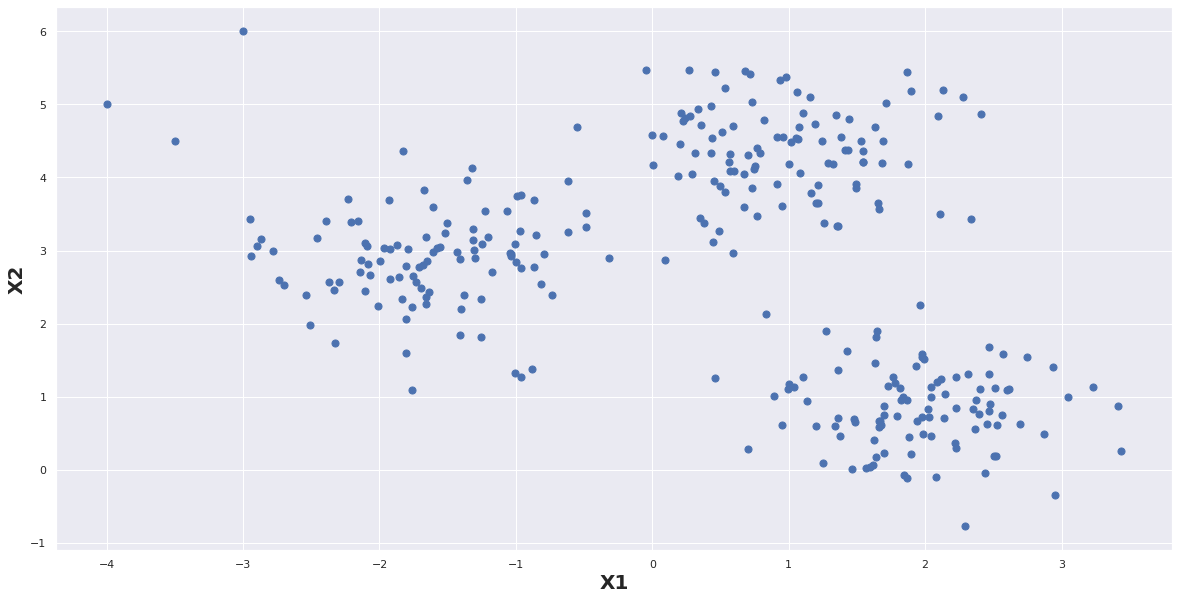

In [59]:
plt.figure(figsize=(20, 10))
plt.scatter(X_out[:, 0], X_out[:, 1], s=50)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

Text(0.5, 0, 'X1')

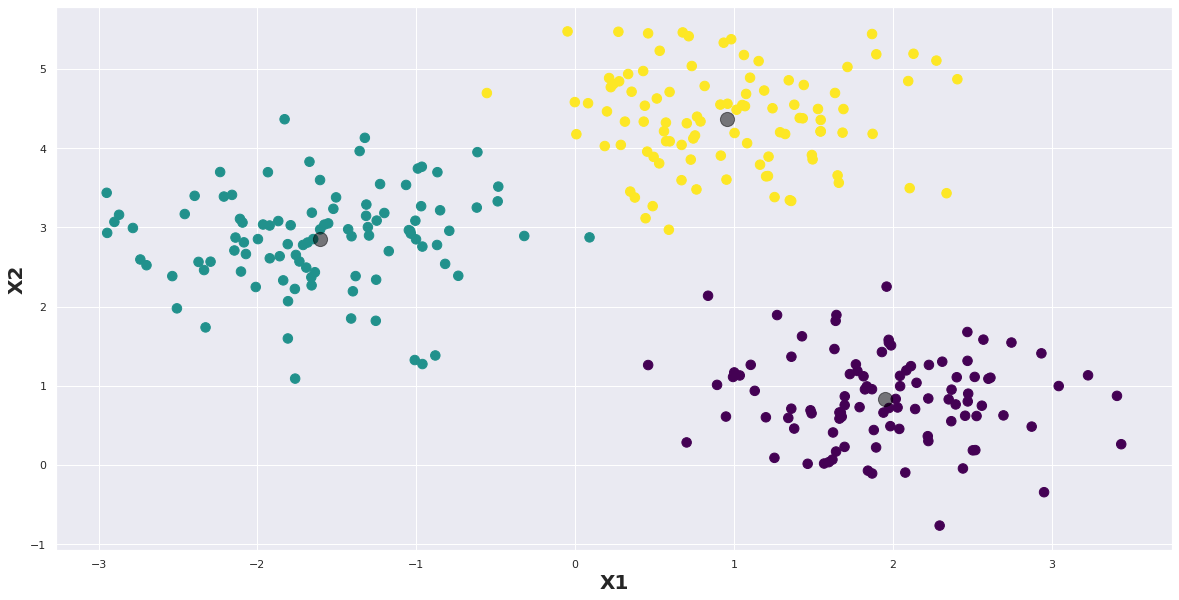

In [60]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=90, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

Text(0.5, 0, 'X1')

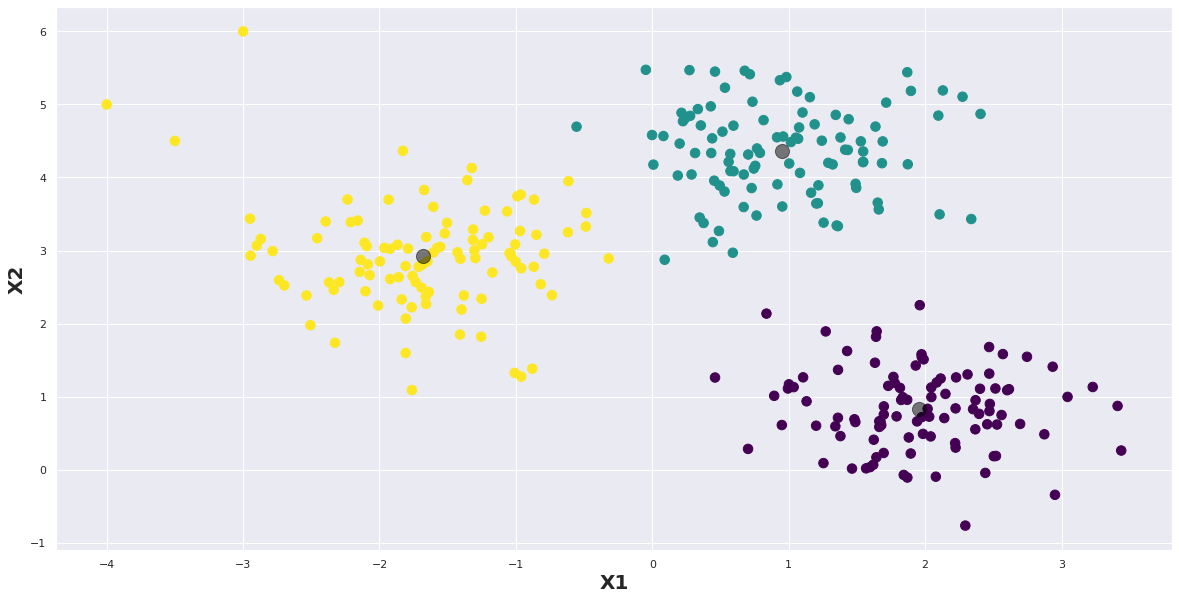

In [61]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_out)
y_kmeans = kmeans.predict(X_out)
plt.figure(figsize=(20, 10))
plt.scatter(X_out[:, 0], X_out[:, 1], c=y_kmeans, s=90, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")


In [62]:
X_out = np.vstack((X_out, ([-25, 3.5])))

Text(0.5, 0, 'X1')

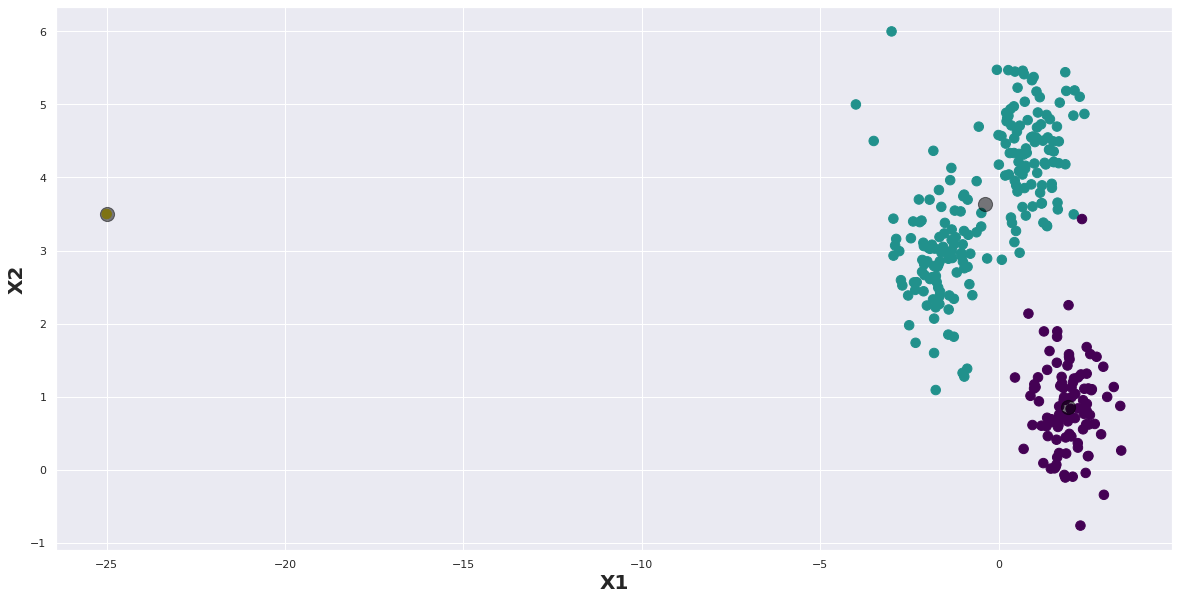

In [63]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_out)
y_kmeans = kmeans.predict(X_out)
plt.figure(figsize=(20, 10))
plt.scatter(X_out[:, 0], X_out[:, 1], c=y_kmeans, s=90, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")


Vemos que el outlier hizo que uno de los clusters, por lo que este método es bastante sensible a outliers. Pensar que con mayor cantidad de dimensiones es más complicado ver outliers. Usando algoritmos jerárquicos se tiene el mismo problema:

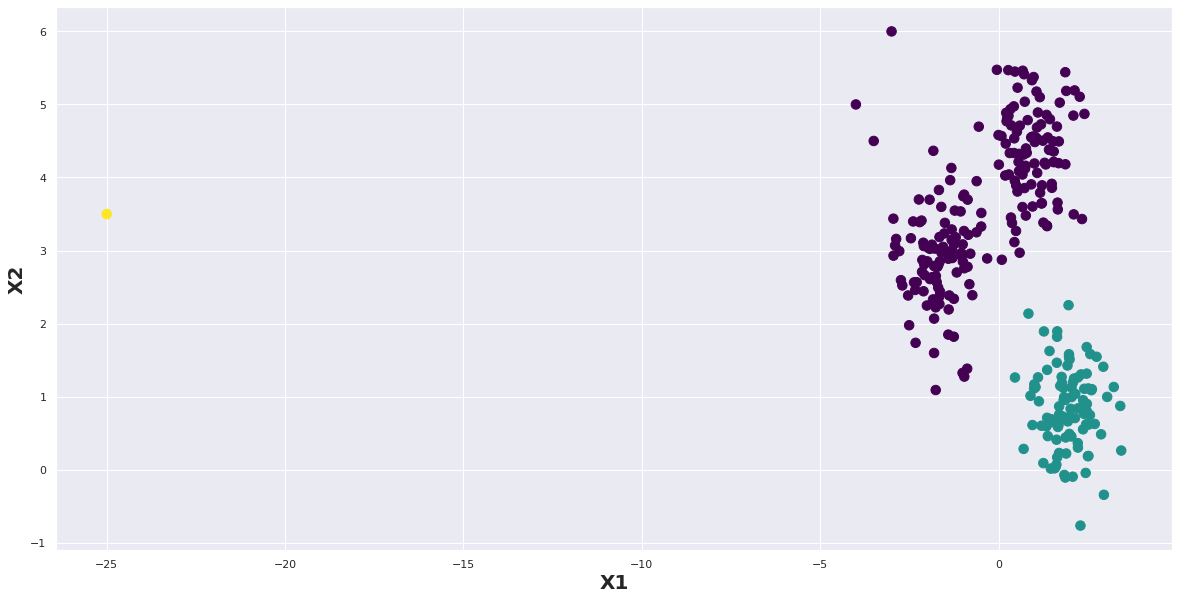

In [64]:
clustering = AgglomerativeClustering(3).fit(X_out)
plt.figure(figsize=(20, 10))
plt.scatter(X_out[:, 0], X_out[:, 1], c=clustering.labels_, s=90, cmap='viridis')
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")
plt.show()

En cambio, BDSCAN al poder clasificar algunos puntos como outliers, puede manejar este tipo de situaciones:

In [65]:
db = DBSCAN(eps=0.7, min_samples=10).fit(X_out)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

Text(0.5, 0, 'X1')

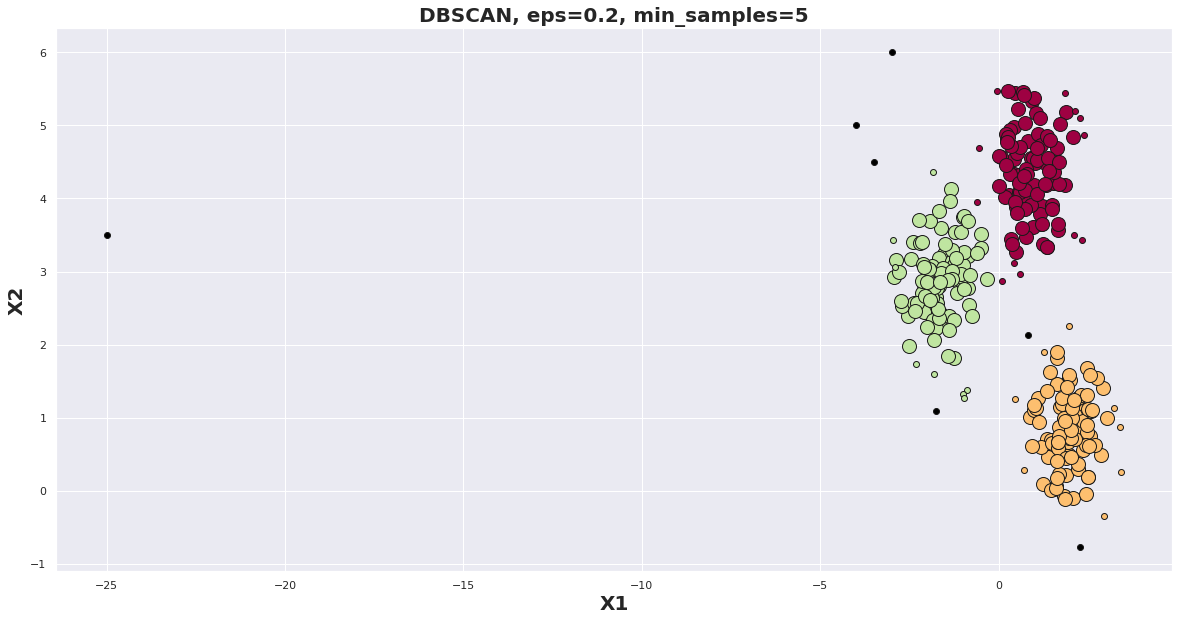

In [66]:
unique_labels = set(labels)
plt.figure(figsize=(20, 10))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X_out[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=14,
    )

    xy = X_out[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
    )

plt.title("DBSCAN, eps=0.2, min_samples=5", fontsize=20, weight="bold")
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

Finalmente, notar que los centroides de kmeans son puntos representativos del cluster. Por ejemplo, si corremos kmeans en el dataset de MNIST:

In [67]:
from sklearn.datasets import load_digits

In [68]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [69]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

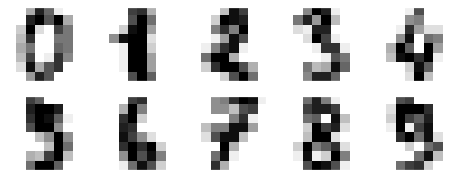

In [70]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = digits.data[:10].reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [71]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

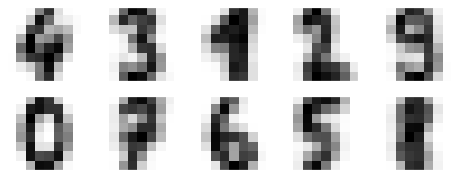

In [72]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)